<a href="https://colab.research.google.com/github/gulshan0201/DATA-Science/blob/main/DS_Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

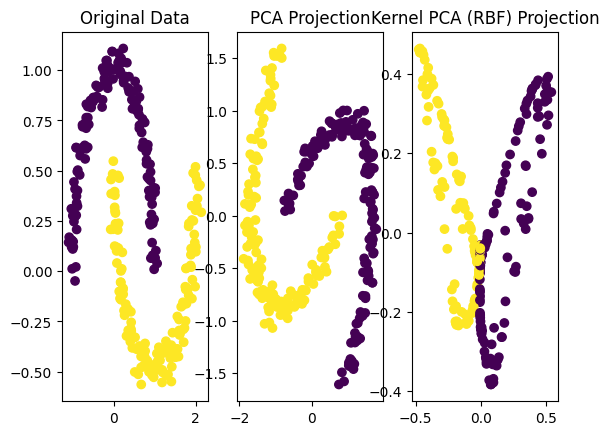

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

# Generate synthetic non-linear dataset (two moons)
X, y = make_moons(n_samples=300, noise=0.05, random_state=42)

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Apply Kernel PCA with RBF kernel
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_kpca = kpca.fit_transform(X_scaled)

# Plot Original Data
plt.subplot(1, 3, 1)
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis')
plt.title("Original Data")

# Plot PCA
plt.subplot(1, 3, 2)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis')
plt.title("PCA Projection")

# Plot Kernel PCA
plt.subplot(1, 3, 3)
plt.scatter(X_kpca[:,0], X_kpca[:,1], c=y, cmap='viridis')
plt.title("Kernel PCA (RBF) Projection")

plt.show()
